![STScI Logo](../../../_static/stsci_header.png)

<a id="topSp"></a>

# Splitting COS Exposures into sub-exposures with `splittag`

# Learning Goals

<font size="4 ">This Notebook is designed to walk the user (<em>you</em>) through:</font><br>
    
**Filtering Cosmic Origins Spectrograph (COS) `TIME-TAG` data using the `splittag` tool** by

**1. [Examining the data to determine how to split the files](#exSpdata)**

**2. [Using `splittag` to create multiple sub-exposure files](#SpSp)**

**3. [Extracting spectra from the sub-exposures using `CalCOS`](#extractSp)**

**4. [Creating multiple sub-exposure files at regular intervals](#reg)**


# 0. Introduction
**The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).**

**This tutorial aims to prepare you to work with the COS data of your choice by walking you through filtering `TIME-TAG` datapoints obtained by COS based on arbitrary times.**

COS Data can be taken in [`TIME-TAG`](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-1-instrument-capabilities-and-design) mode, in which each individual encounter with a photon is recorded with its own metadata such as the time of the encounter. You may wish to split a COS exposure into multiple sub-exposure files. For instance, a transit may occur during your exposure, and you may wish to see the difference between the source's spectrum before, during, and after the transit. This is possible with `TIME-TAG` data, and the functionality to do this is built into the [`COSTools` python module](https://github.com/spacetelescope/costools) with the tool `splittag`. 

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).
- The code for the `splittag` tool is found on the [spacetelescope/costools GitHub repository](https://github.com/spacetelescope/costools/blob/master/costools/splittag.py)

<font size="5"> We will import the following packages:</font>

- `costools splittag` to select `TIME-TAG` datapoints by their time of encounter
- `calcos` to re-process the data
- `numpy` to handle array functions
- `astropy.table Table` for reading FITS file data
- `glob`, `os`, and `Path` for working with system files
- `matplotlib.pyplot` for plotting data
- `astroquery.mast Mast` and `Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `warnings` and `astropy.units Warnings` for suppressing a warning that is not helpful later on.

New versions of `CalCOS` are currently incompatible with astroconda. To create a Python environment capable of running all the data analyses in these COS Notebooks, please see Section 1 of our Notebook tutorial on [setting up an environment](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/Setup/Setup.ipynb). Your version of `costools` may display a message on input about `TEAL` support (described [here](#tealST)), but you may ignore this as it is largely irrelevant to our discussion.

In [1]:
# For array manipulation
import numpy as np

# For reading FITS files
from astropy.table import Table

# For plotting
import matplotlib.pyplot as plt

# For filtering time-tag events by time
from costools import splittag

# For processing COS data
import calcos

# For system files
import glob
import os
from pathlib import Path

# For downloading the data
from astroquery.mast import Observations

# For supressing an unhelpful warning:
import warnings
from astropy.units import UnitsWarning

from IPython.display import clear_output

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/costools/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


<font size="5"> We will also define a few directories we will need: </font>

In [2]:
# Using the pathlib style of system path
output_dir = Path('./output/')
plots_dir = output_dir / 'plots'

# Make the directories in case they don't exist
output_dir.mkdir(exist_ok=True)
plots_dir.mkdir(exist_ok=True)

<font size="5"> And we will need to download the data we wish to filter and analyze </font>

We choose the exposure with obs_id: `lc1va0010`, because we happen to know it contains an exposure taken while the target, [IY UMa](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=IY+UMa), underwent a transit event. For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/DataDl/DataDl.ipynb).

We will download `corrtag` files for both segments. The `corrtag` file is a corrected events list for `TIME-TAG` data (more info in the [Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-4-cos-data-products#:~:text=Science%20Data%20Files-,Corrected%20Events%20Lists%20(corrtag),-The%20COS%20pipeline)). In the [next section](#exSpdata), we will use this file to create a rough light curve of the exposure.

In [3]:
# Find all MAST data on this obs_id:
pl = Observations.get_product_list(Observations.query_criteria(
                                    obs_id='lc1va0010'))

# Filter and download the Corrtag TIME-TAG files:
pl_filt = Observations.filter_products(
    pl, productSubGroupDescription=('CORRTAG_A', 'CORRTAG_B')
)
downloaded_corrtags = Observations.download_products(pl_filt)['Local Path']

# Let us know how many corrtags were found:
print(
    f"#####\nFound {len(downloaded_corrtags)} corrtag exposure "
    "files from the COS FUV detector (segment A only)")

INFO: Found cached file ./mastDownload/HST/lc1va0yeq/lc1va0yeq_corrtag_a.fits with expected size 5567040. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0yjq/lc1va0yjq_corrtag_a.fits with expected size 4132800. [astroquery.query]


INFO: Found cached file ./mastDownload/HST/lc1va0zcq/lc1va0zcq_corrtag_a.fits with expected size 14791680. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0zgq/lc1va0zgq_corrtag_a.fits with expected size 8596800. [astroquery.query]
#####
Found 4 corrtag exposure files from the COS FUV detector (segment A only)


<a id= exSpdata></a>
# 1. Examining the data to determine how to split the files
We chose this dataset because of its transit event. However, let's suppose for a moment that we don't know which, if any, of our exposures have transits or other time-variable events. We'll imagine we are simply investigating our data.

**To look for transits and other anomalies, we will create and examine a rough lightcurve of our four exposures.**

A [lightcurve](https://en.wikipedia.org/wiki/Light_curve) is simply a graph of net light or photon counts over time. We can make one by grabbing the time of all recorded photon events from each exposure, and plotting a histogram of the times. There are packages which can create detailed lightcurves, such as the [lightcurve](https://github.com/justincely/lightcurve) package, but we will make these simple lightcurve plots ourselves. We also do not claim to explain every feature of all the lightcurves created. We will focus on any clear transit shapes.

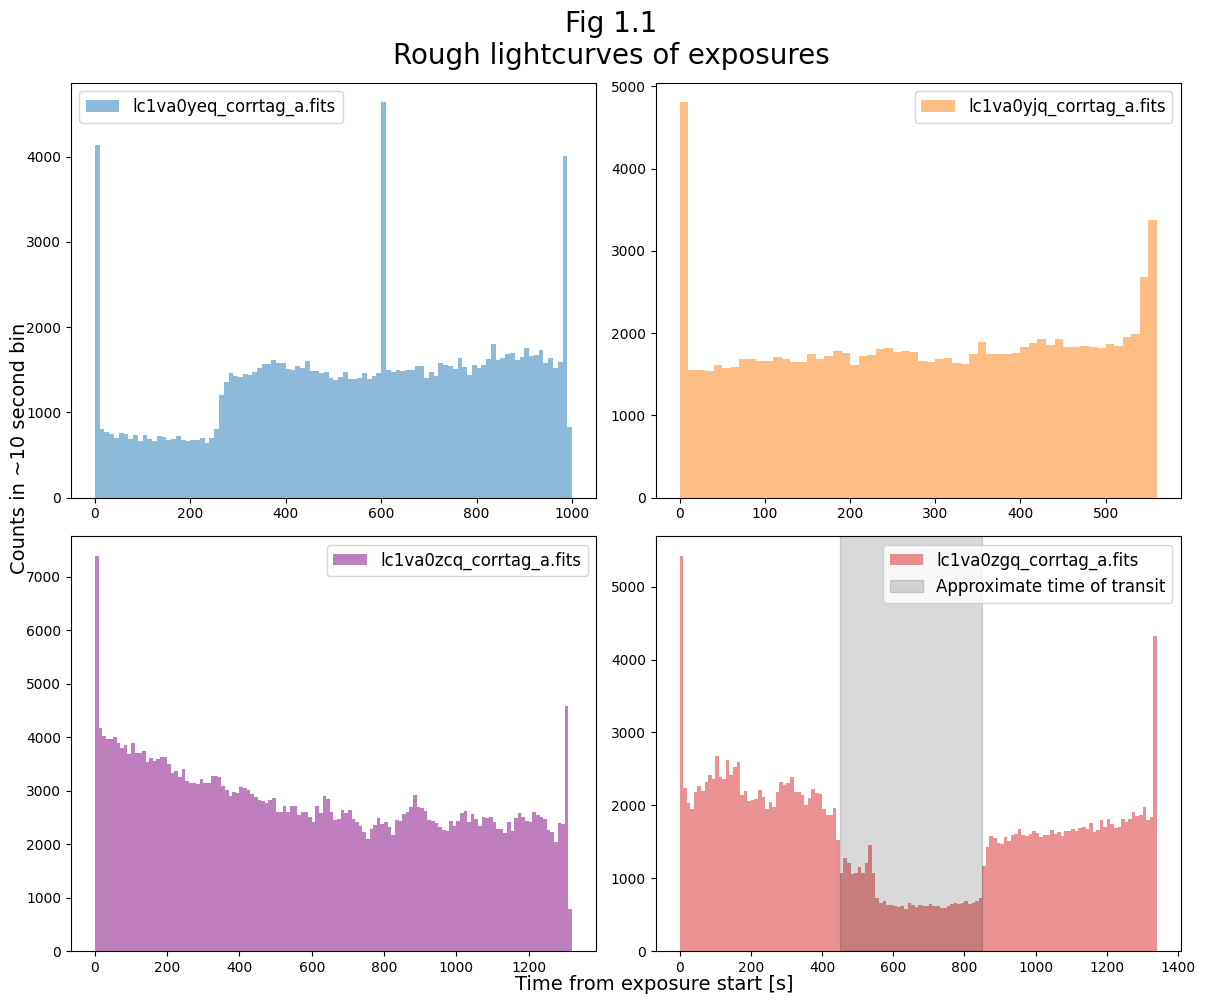

In [4]:
# Build the figure structure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2,
                         figsize=(12, 10))

# Get the time data for each exposure
# Number of seconds in a bin
binsize = 10
for i, ctag in enumerate(downloaded_corrtags):
    # Make the subplot
    ax = fig.add_subplot(axes[int(i/2), i % 2])
    # Read the data into a table
    ctab = Table.read(ctag, 1)
    event_times = ctab['TIME']
    # Plot the histogram of times
    hist = ax.hist(
        event_times,
        bins=np.arange(0, max(event_times)+binsize, binsize),
        alpha=0.5,
        label=os.path.basename(ctag),
        color=['C0', 'C1', 'purple', 'C3'][i]
    )
    # Add a gray box around the suspected transit:
    if "zgq" in ctag:
        ax.axvspan(
            450, 850,
            color='k',
            alpha=0.15,
            label="Approximate time of transit"
        )
        # Storing the path of this transit exposure for next cell
        transit_exp = ctag
    plt.legend(fontsize=12)

# Format the figure and add text:
plt.suptitle("Fig 1.1\nRough lightcurves of exposures",
             fontsize=20)
fig.text(
    x=0.42, y=-0.0001,
    s="Time from exposure start [s]",
    fontsize=14
)
fig.text(
    y=0.42, x=-0.001,
    s=f"Counts in ~{binsize} second bin",
    rotation='vertical',
    fontsize=14
)

plt.tight_layout()

plt.savefig(plots_dir / 'compare_exposures.png',
            bbox_inches='tight',
            dpi=200)

We can see an apparent transit in the exposure `lc1va0zgq`, occurring from about 450 - 850 seconds into the exposure. We highlight this in Figure 1.2 below.

Exposure `lc1va0yeq` also seems to contain at least the latter part of a transit, but for now we'll focus on `lc1va0zgq`.

The length of the exposure is ~1337 s


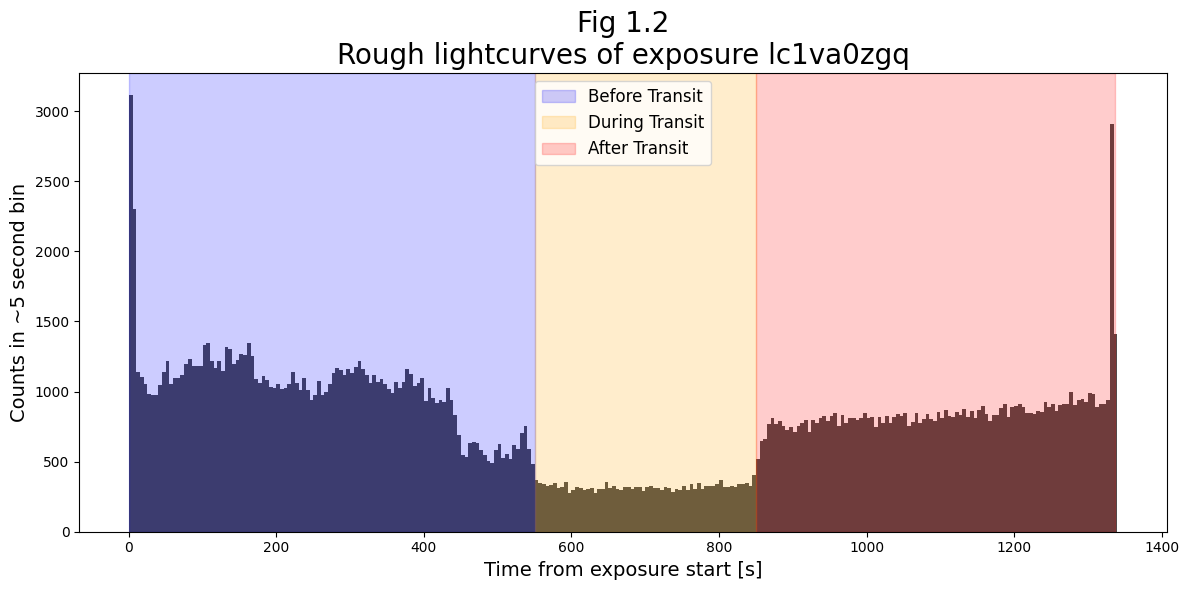

In [5]:
# Create the plot:
fig = plt.figure(figsize=(12, 6))

# Select the data and plot it:
# Binsize in seconds
binsize = 5
# Reading the corrtag table for this exposure
ctab = Table.read(transit_exp, 1)
# Getting the event times
event_times = ctab['TIME']
hist = plt.hist(event_times,
                bins=np.arange(0, max(event_times)+binsize, binsize),
                color='k',
                alpha=0.7)

# Add time ranges "epochs" or "windows of time" as transparent spans:
epoch_markers = [(0, 550), (550, 850), (850, max(event_times))]
print(f"The length of the exposure is ~{int(max(event_times))} s")
epoch_labels = ["Before Transit", "During Transit", "After Transit"]

# Adding color to distinguish before, during, and after the transit
for epoch_time, epoch_label, color in zip(epoch_markers, epoch_labels, ['b', 'orange', 'r']):
    plt.axvspan(
        epoch_time[0], epoch_time[1],
        color=color,
        alpha=0.2,
        label=epoch_label
    )

# Format the Figure
plt.legend(fontsize=12)

# Getting the transit file basename
transit_basename = transit_exp.split('/')[3]

plt.title(f"Fig 1.2\nRough lightcurves of exposure {transit_basename}",
          size=20)
plt.xlabel("Time from exposure start [s]",
           fontsize=14)
plt.ylabel(fr"Counts in ~{binsize} second bin",
           fontsize=14)

plt.tight_layout()

plt.savefig(plots_dir / 'examine_transit.png',
            bbox_inches='tight',
            dpi=200)

**We now wish to actually split the file into three sub-exposures with the counts gathered during these three windows of time.**

For research purposes, the transit should be measured more carefully than simply looking at this rough lightcurve. However for our purposes, we explicitly and somewhat arbitrarily define the windows, 'by eye', as:

|Window|Time Range|
|-|-|
|Before Transit| 0-550 seconds|
|During Transit| 550-850 seconds|
|After Transit| 850-1337 seconds|


<a id=SpSp></a>
# 2. Using `splittag` to create multiple sub-exposure files


The next cell creates a directory for the sub-exposure files we're about to create, and uses `splittag` to split the exposures.

The `time_list` parameter defines the times at which the exposure will be split. Because we pass this parameter the list `[0, 550, 850, <time of last recorded count>]`, `splittag` will produce 3 sub-exposure files with data taken from:
1. 0-550 seconds
2. 550-850 seconds
3. 850-1337 seconds (because the `<time of last recorded count>` for this exposure ~1337 s)

*Please note* that `splittag` will **not** overwrite files if you run it multiple times. Instead, it will write a new set of files with increasing numeric suffixes (e.g. `filepath_corrtag_a.fits` --> `filepath_1_corrtag_a.fits`). This can cause issues if you do not update your filepaths to the output files you wish to use. To prevent problems, we will delete any older `corrtag` files in the directory. If you do not wish to delete your old files, set the `delete_old_files` variable to `False` in the cell below. Alternatively, you may wish to create a new directory for each time you run `splittag`. Please take care to prevent these issues when attempting the exercises, as well. You may ignore any `AstropyDeprecationWarnings` about keywords. 

In [6]:
# Make the folder in which to store the newly split corrtag files:
spec_int_dir = output_dir / 'spec_intervals'
# An output directory for files split on specified intervals
spec_int_dir.mkdir(exist_ok=True)

# Use CAUTION when deleting files - as in the next lines:

# These lines delete existing processed files in the output directory
# If you have run this cell before, this will overwrite previous outputs
delete_old_files = True
if delete_old_files and any(spec_int_dir.glob("*corrtag*fits")):
    print("Deleting files from a previous run...")
    [old_f.unlink() for old_f in list(spec_int_dir.glob("*corrtag*fits"))]

# Print info to the user:
print("Creating and writing split files...")
for i, epoch_times in enumerate(epoch_markers):
    print(
        f"> File {i+1} contains counts from time:",
        f"{epoch_times[0]} - {epoch_times[1]} seconds"
    )

split_list = [0, 550, 850, max(event_times)]

# Run splittag using our specified times:
splittag.splittag(infiles=transit_exp,
                  outroot=f'./output/spec_intervals/{transit_basename}',
                  time_list=split_list)

Deleting files from a previous run...
Creating and writing split files...
> File 1 contains counts from time: 0 - 550 seconds
> File 2 contains counts from time: 550 - 850 seconds
> File 3 contains counts from time: 850 - 1337.2159423828125 seconds


./output/spec_intervals/lc1va0zgq_1_corrtag_a.fits written


./output/spec_intervals/lc1va0zgq_2_corrtag_a.fits written


./output/spec_intervals/lc1va0zgq_3_corrtag_a.fits written


**Excellent! We've now created 3 sub-exposure files.**

Below, we show the lightcurves of sub-exposure files which resulted from splitting at the specified intervals.

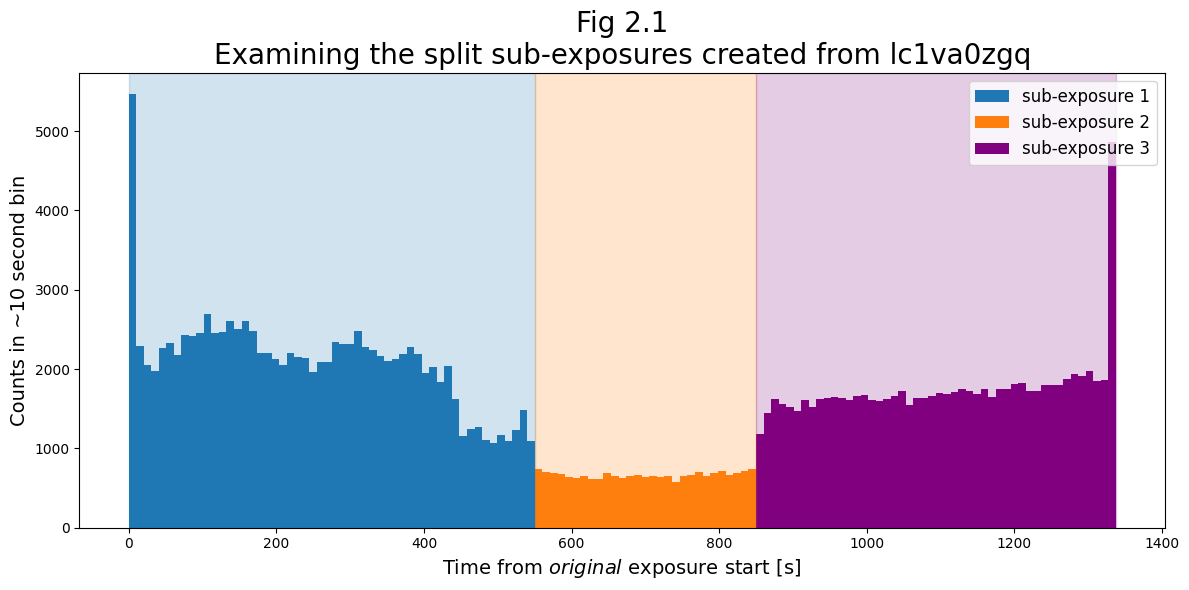

In [7]:
# Create the plot:
fig = plt.figure(figsize=(12, 6))

# Gather the split sub-exposure files:
spec_outlist = sorted(glob.glob('./output/spec_intervals/*fits'))

# Make histogram lightcurves as in previous plots:

# Binsize of lightcurve histogram in seconds
binsize = 10
# For each of our newly split up files:
for i in range(len(spec_outlist)):
    splitfile = spec_outlist[i]
    epoch_number = splitfile.split('_')[2]
    # Read in the file as a table of events:
    events_table = Table.read(splitfile, 1)
    event_times = events_table['TIME']
    hist = plt.hist(
        event_times,
        bins=int((max(event_times)-min(event_times))/binsize),
        alpha=1,
        color=['C0', 'C1', 'purple'][i],
        label=f"sub-exposure {epoch_number}"
    )

# Add time ranges "epochs" or "windows of time" as transparent spans:
for epoch_time, color in zip(epoch_markers, ['C0', 'C1', 'purple']):
    plt.axvspan(
        epoch_time[0], epoch_time[1],
        color=color,
        alpha=0.2,
        label=None
    )

# Format the Figure
plt.legend(fontsize=12)

plt.title("Fig 2.1\nExamining the split sub-exposures created "
          + f"from {transit_basename}",
          size=20)
plt.xlabel("Time from $original$ exposure start [s]",
           fontsize=14)
plt.ylabel(fr"Counts in ~{binsize} second bin",
           fontsize=14)

plt.tight_layout()

plt.savefig(plots_dir / 'subexps.png',
            bbox_inches='tight',
            dpi=200)

Now that we have the three sub-exposure files, we can process them into 1-dimensional spectra using the [COS Calibration Pipeline: `CalCOS`](https://github.com/spacetelescope/calcos).

### Exercise 1: *Practice sub-dividing with `splittag`*

Examining Fig 2.1, we see that from approximately 450-550 seconds, there is are in fact 2 drops in flux. Starting from an initial flux similar to that at the start of the exposure, the flux drops first by ~50% at around 450 seconds, and then drops by ~75% at around 550 seconds to its depth for the duration of the transit.

Separate out the data taken during this initial drop (from ~450-550 seconds) into its own sub-exposure file using `splittag`. Then, demonstrate your split files with a lightcurve like that in Fig 2.1.

In [8]:
# Your code here:

<a id=extractSp></a>
# 3. Extracting spectra from the sub-exposures using `CalCOS`

While for most circumstances, `CalCOS` is best run on an association file, (a FITS table which specifies a series of exposures to calibrate and combine into a spectrum,) the `CalCOS` pipeline can usually be run on individual `rawtag` or `corrtag` files. 

* More information on running `CalCOS` can be found in [Chapter 3.6 of the COS Instrument Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-6-customizing-cos-data-calibration#id-3.6CustomizingCOSDataCalibration-3.6.1MechanicsofTailoredRecalibration)
* An interactive walkthrough to running the `CalCOS` can be found in [our notebook on the `CalCOS` pipeline](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/CalCOS/CalCOS.ipynb).

<a id=setlref></a>
## 3.1 Getting the `lref` reference files
To run `CalCOS`, your computer will need an `lref` system variable to tell the pipeline where to find your reference files. If you are on the STScI internet network (including via VPN), you may set this to the shared Institute `lref` directory. However, if you're not on the network, you will need to use the `CRDS` command to download the necessary reference files. This process is described in detail in Chapter 3 of our [notebook on setting up an environment for working with COS data](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/Setup/Setup.ipynb#crdsS). 

The code in this cell ensures that the "lref" path is correctly set in the environment variables and the crds files will be downloaded. 

In [9]:
os.environ["CRDS_SERVER_URL"] = "https://hst-crds.stsci.edu"
os.environ["CRDS_PATH"] = './crds_cache'
os.environ['lref'] = "./crds_cache/references/hst/cos"

! crds bestrefs --files mastDownload/HST/**/lc1va0*.fits --sync-references=1  --update-bestrefs
clear_output()

<a id=#runcalcos></a>
## 3.2 Running `CalCOS` and processing sub-exposure files
**We can now run the pipeline on each of our new sub-exposure files to create processed spectra based on data taken in the three time periods.**

The cells may take several minutes to run. 

In [10]:
# When we run CalCOS on corrtags, we must go 1-by-1
for split_corrtag in spec_outlist:
    # Define epoch as chunk of the initial exposure. epoch 2 = the transit.
    epoch_number = os.path.basename(split_corrtag).split('_')[1]
    print(f"Extracting file {split_corrtag} using CalCOS")

    # Make a sub-directory of output/calcos/ named for each epoch:
    cal_output_dir = f'./output/calcos/epoch{epoch_number}/'
    os.makedirs(cal_output_dir, exist_ok=True)

    # Extract the spectrum from each of the sub-exposures:
    try:
        calcos.calcos(split_corrtag,
                      outdir=cal_output_dir,
                      verbosity=0)
    except RuntimeError as e:
        print('An error occured', e)

# Print a message at the end to let us know it's finished:
print("Done running the pipeline.")

Extracting file ./output/spec_intervals/lc1va0zgq_1_corrtag_a.fits using CalCOS
CALCOS version 3.6.1


numpy version 2.3.5


astropy version 7.1.1


Begin 25-Nov-2025 00:55:38 UTC


ERROR:  output files already exist:


ERROR:    ./output/calcos/epoch1/lc1va0zgq_1_corrtag_a.fits


ERROR:    ./output/calcos/epoch1/lc1va0zgq_1_flt_a.fits


ERROR:    ./output/calcos/epoch1/lc1va0zgq_1_counts_a.fits


ERROR:    ./output/calcos/epoch1/lc1va0zgq_1_x1d.fits


An error occured output files already exist
Extracting file ./output/spec_intervals/lc1va0zgq_2_corrtag_a.fits using CalCOS
CALCOS version 3.6.1


numpy version 2.3.5


astropy version 7.1.1


ERROR:  output files already exist:


ERROR:    ./output/calcos/epoch2/lc1va0zgq_2_corrtag_a.fits


ERROR:    ./output/calcos/epoch2/lc1va0zgq_2_flt_a.fits


ERROR:    ./output/calcos/epoch2/lc1va0zgq_2_counts_a.fits


ERROR:    ./output/calcos/epoch2/lc1va0zgq_2_x1d.fits


An error occured output files already exist
Extracting file ./output/spec_intervals/lc1va0zgq_3_corrtag_a.fits using CalCOS
CALCOS version 3.6.1


numpy version 2.3.5


astropy version 7.1.1


ERROR:  output files already exist:


ERROR:    ./output/calcos/epoch3/lc1va0zgq_3_corrtag_a.fits


ERROR:    ./output/calcos/epoch3/lc1va0zgq_3_flt_a.fits


ERROR:    ./output/calcos/epoch3/lc1va0zgq_3_counts_a.fits


ERROR:    ./output/calcos/epoch3/lc1va0zgq_3_x1d.fits


An error occured output files already exist
Done running the pipeline.


**Now, we can examine our newly processed spectra**

We first examine the entire spectrum:

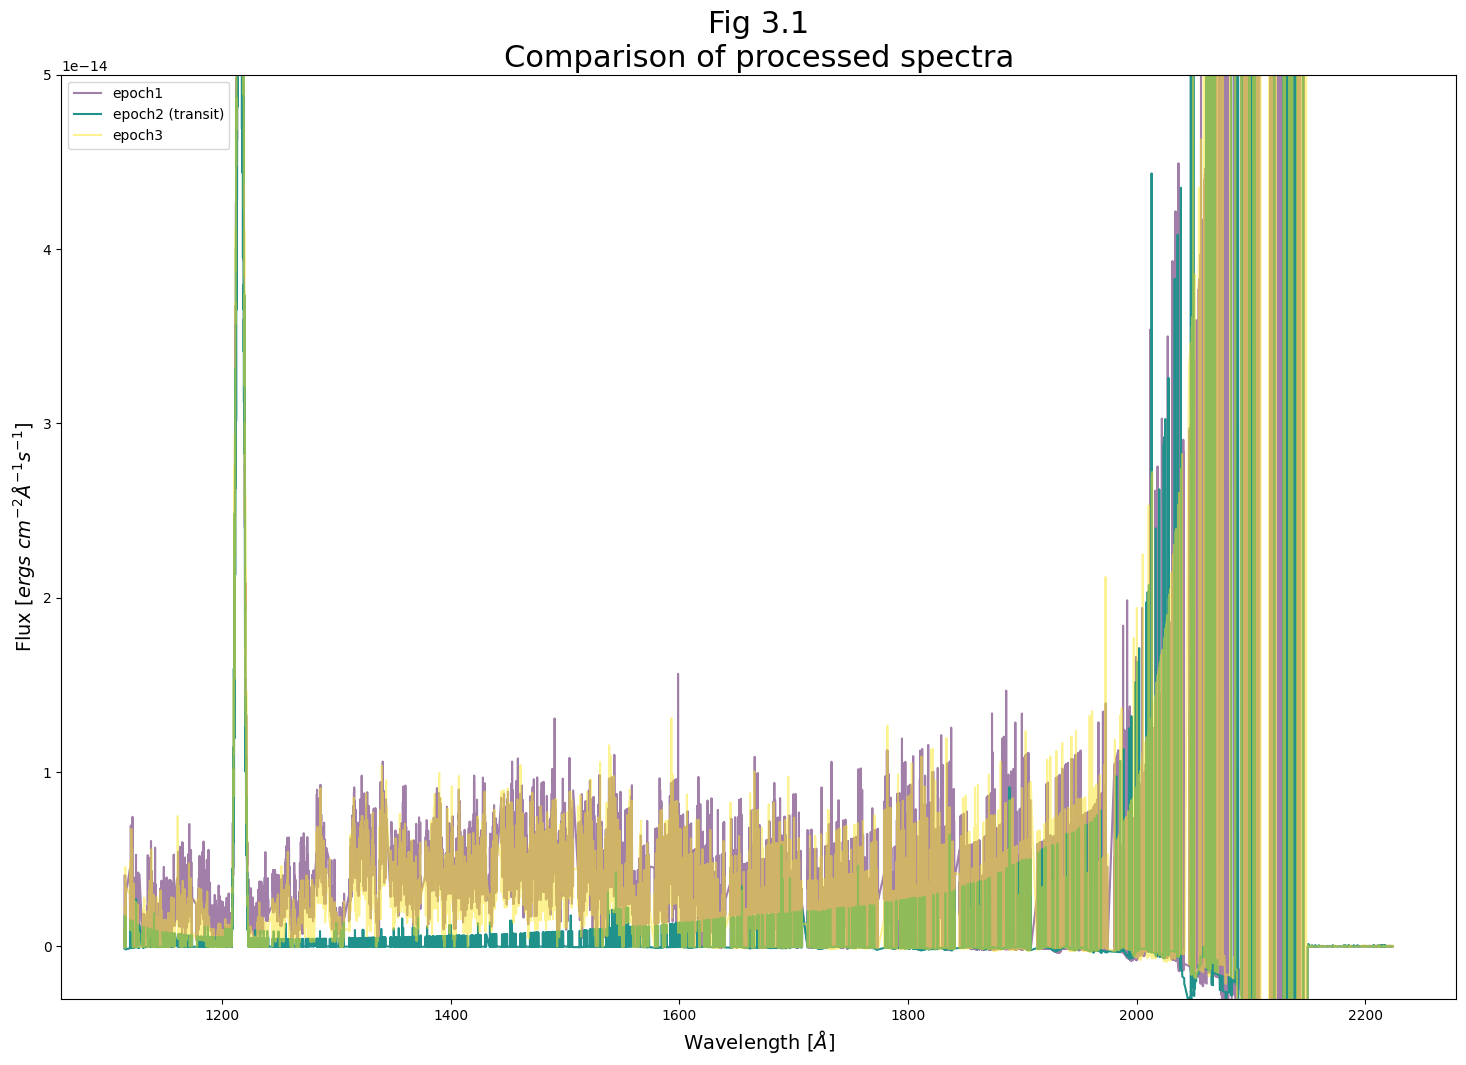

In [11]:
# Find all the `x1d` files:
processed_files = sorted(glob.glob('output/calcos/epoch*/*x1d.fits'))
num_files = len(processed_files)

cmap = plt.colormaps.get_cmap('viridis')
colors = np.linspace(0, 1, len(processed_files))

# Set up figure
plt.figure(figsize=(18, 12))

# Loop through
for i in range(len(processed_files)):
    epoch_label = processed_files[i].split('/')[2]

    # Mark the transit
    if "2" in epoch_label:
        epoch_label += " (transit)"
        alpha_value = 1
    else:
        alpha_value = 0.5

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',
                                category=UnitsWarning,
                                append=True)

        w, f, ferr, dq = Table.read(
            processed_files[i])[0]['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']

    # Filter to good quality data
    dq_mask = np.where(dq == 0)
    w, f, ferr = w[dq_mask], f[dq_mask], ferr[dq_mask]

    # Plot each epoch
    plt.plot(w, f,
             # Epoch2 should stand out
             alpha=alpha_value,
             c=cmap(colors[i]),
             # Label with the epoch name
             label=epoch_label)

# Format plot
plt.ylim(-3E-15, 5E-14)

plt.title("Fig 3.1\nComparison of processed spectra",
          size=22)
plt.xlabel(r"Wavelength [$\AA$]",
           size=14)
plt.ylabel(r"Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]",
           size=14)

plt.legend()

plt.savefig(plots_dir / "Compare_spectrum.png",
            dpi=200)

Now we can take a closer look at two spectral regions the region from 1200 - 1230 and from 1250 - 1350 Angstroms.
In the first region, we see the 1215 Angstrom Lyman-alpha line, much of which is [generated by geocoronal emission](https://www.stsci.edu/hst/instrumentation/cos/calibration/airglow). At this line, the flux of the the three epochs is very similar, because the transit in the IY UMa system has no effect on Earth's atmosphere. There are slight differences because the sun's changing position in the sky changes the geocoronal glow. This causes the third sub-exposure to have a slightly higher Lyman-alpha line. However these are small differences compared to the flux of these lines.

For this and the following plots, we will plot the errors as well, to see if the apparent differences in flux between epochs are significant.

#### **For the 1200 - 1230 Angstrom region:**

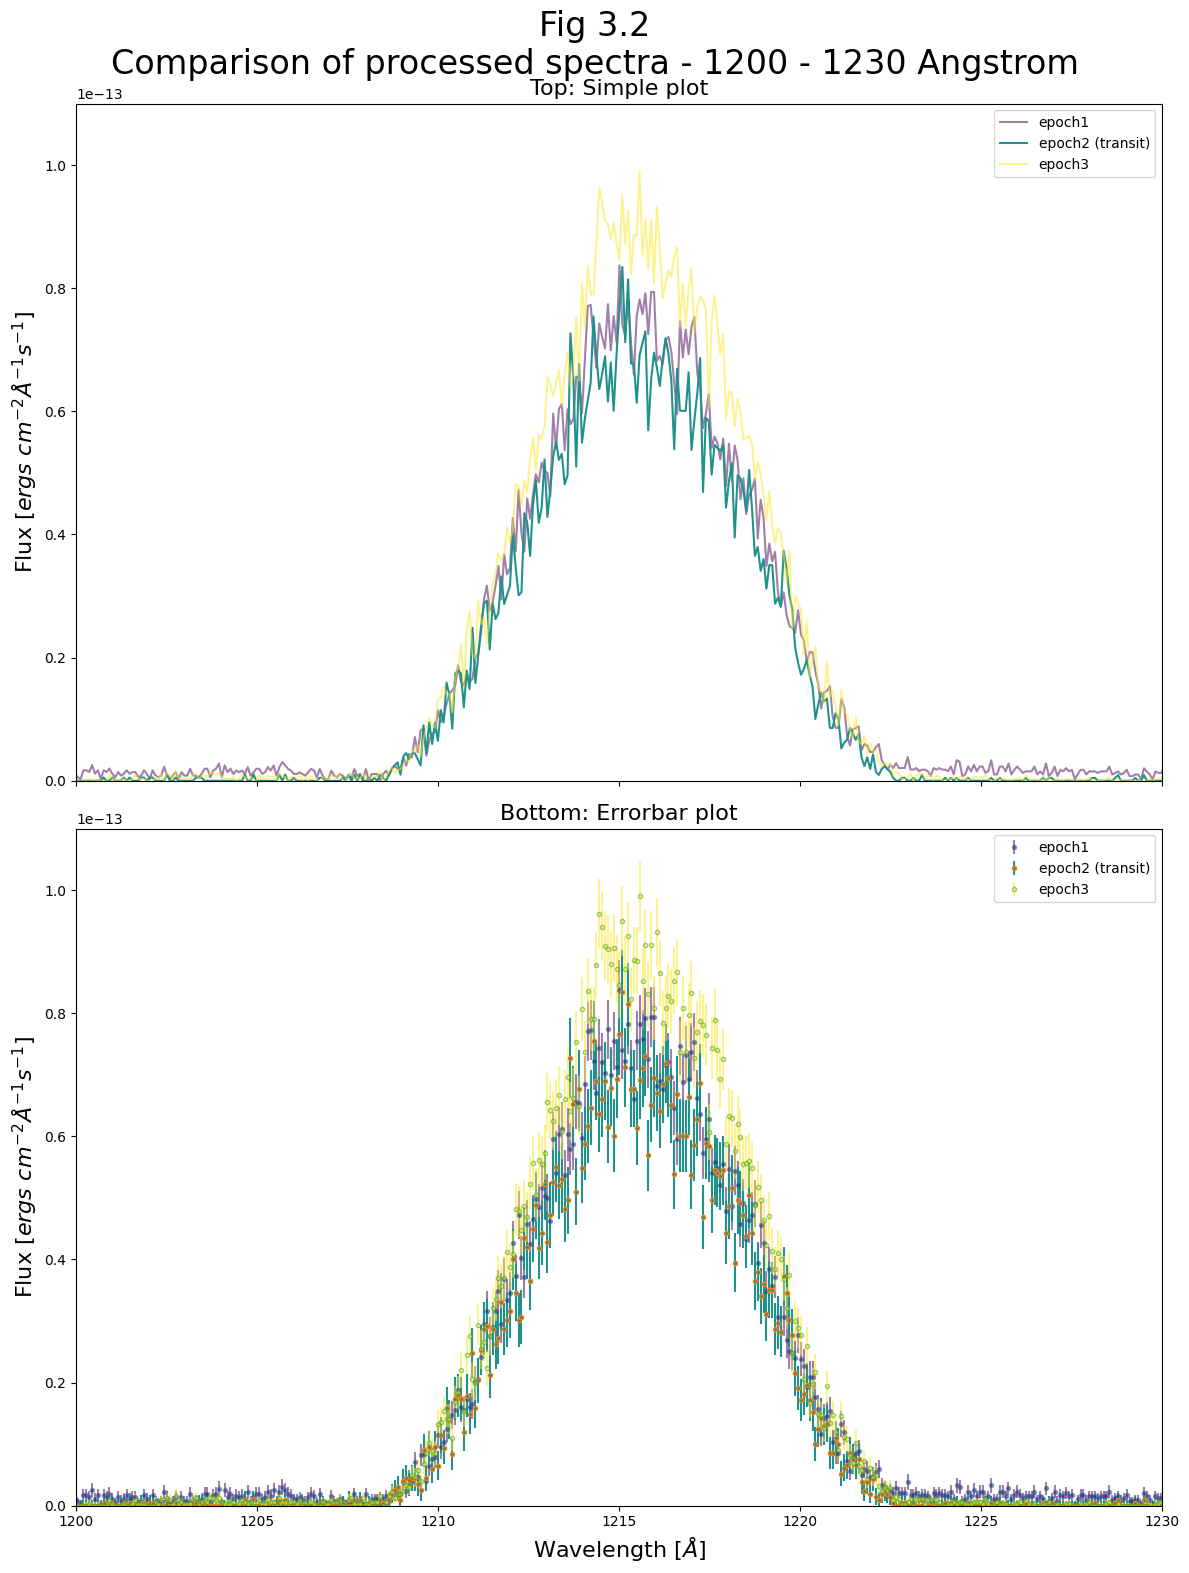

In [12]:
# Set up figure
fig, (ax0, ax1) = plt.subplots(2, 1,
                               figsize=(12, 16),
                               sharex=True)

for i in range(len(processed_files)):
    epoch_label = processed_files[i].split('/')[2]
    if "2" in epoch_label:
        epoch_label += " (transit)"
        alpha_value = 1
    else:
        alpha_value = 0.5

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',
                                category=UnitsWarning,
                                append=True)

        w, f, ferr, dq = Table.read(
            processed_files[i])[0]['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']

    # Filter to good quality data
    dq_mask = np.where(dq == 0)
    w, f, ferr = w[dq_mask], f[dq_mask], ferr[dq_mask]

    # Plot each epoch
    ax0.plot(w, f,
             # Epoch2 should stand out
             alpha=alpha_value,
             c=cmap(colors[i]),
             linestyle='-',
             # Label with the epoch name
             label=epoch_label)

    # Plot each epoch
    ax1.errorbar(w, f, yerr=ferr,
                 # Epoch2 should stand out
                 alpha=alpha_value,
                 marker='.',
                 markerfacecolor=cmap(colors[i]),
                 linestyle='',
                 ecolor=cmap(colors[i]),
                 # Label with the epoch name
                 label=epoch_label)

# Format both subplots
ax0.set_xlim(1200, 1230)
ax0.set_ylim(0, 1.1E-13)
ax1.set_ylim(0, 1.1E-13)

ax0.set_title("Top: Simple plot",
              fontsize=16)
ax1.set_title("Bottom: Errorbar plot",
              fontsize=16)
plt.suptitle(
    "Fig 3.2\nComparison of processed spectra - 1200 - 1230 Angstrom",
    size=24
)

ax1.set_xlabel(r"Wavelength [$\AA$]",
               size=16)
ax0.set_ylabel(r"Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]",
               size=16)
ax1.set_ylabel(r"Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]",
               size=16)

ax0.legend()
ax1.legend()

plt.tight_layout()

plt.savefig(plots_dir / "Compare_spectrum_zoom_1215A.png",
            dpi=200)

#### **For the 1250 - 1350 Angstrom region:**

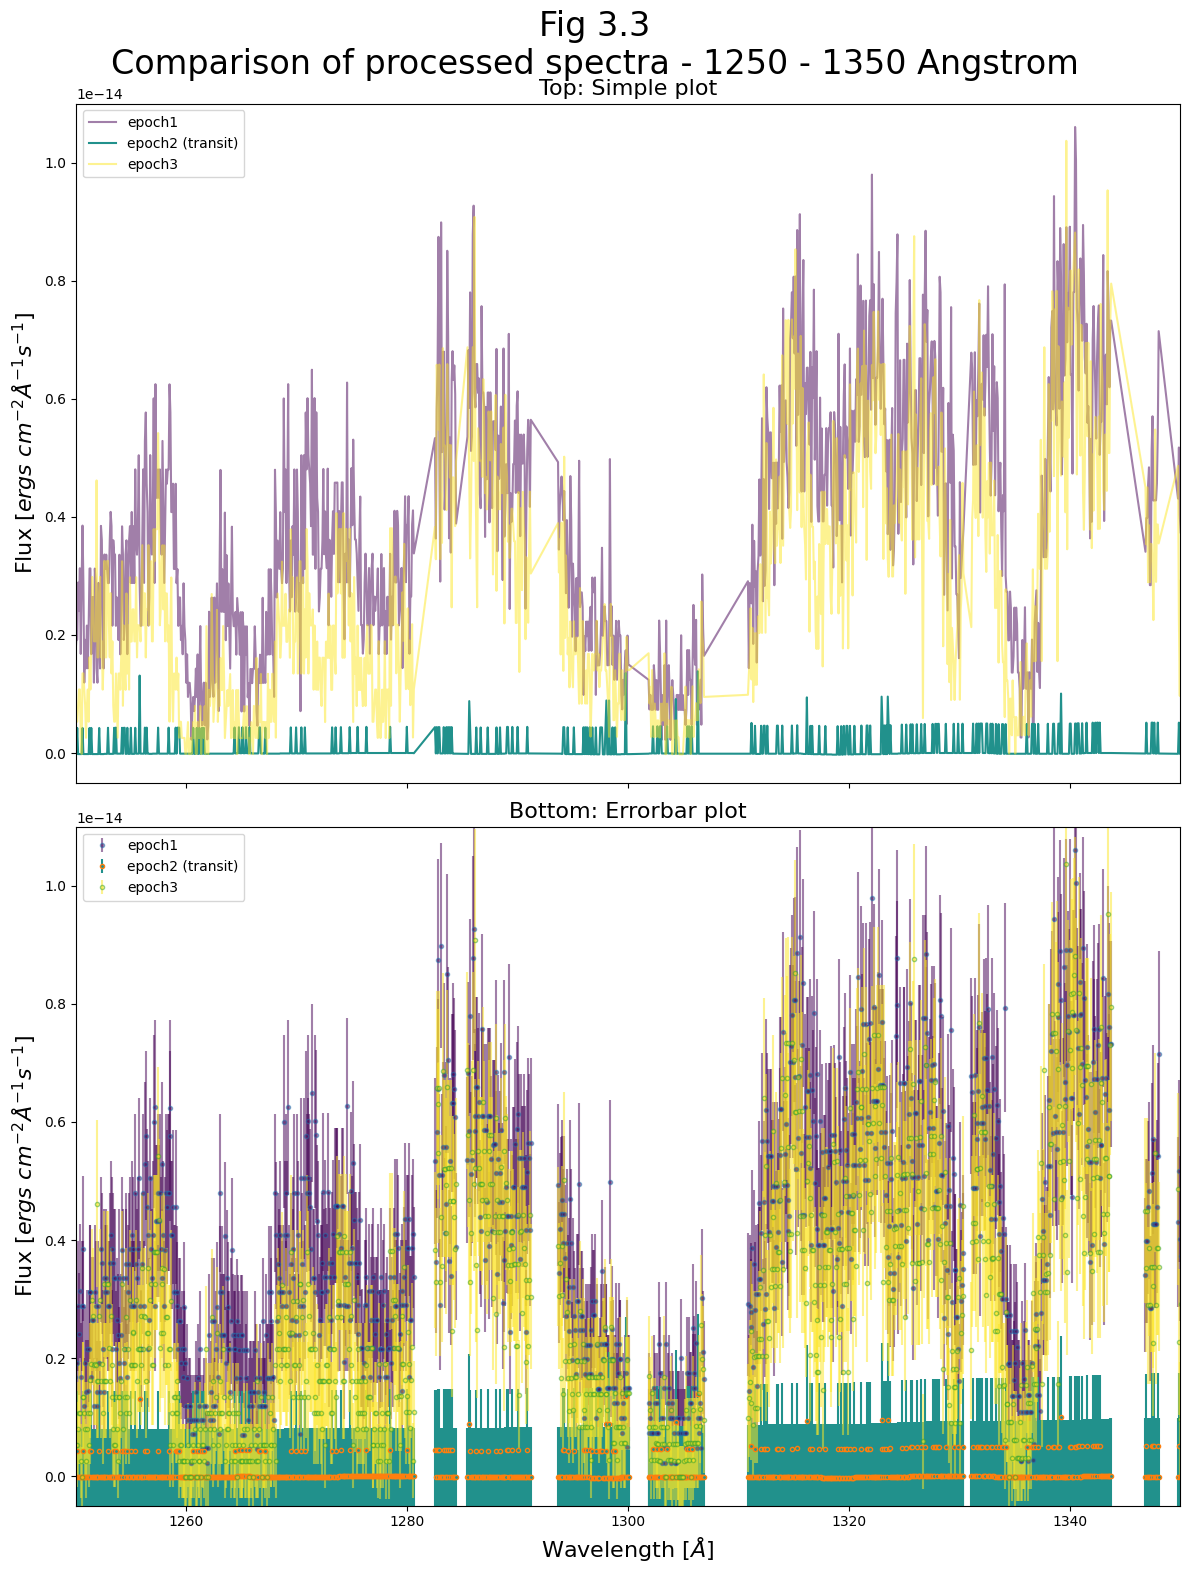

In [13]:
# Set up figure
fig, (ax0, ax1) = plt.subplots(2, 1,
                               figsize=(12, 16),
                               sharex=True)

for i in range(len(processed_files)):
    epoch_label = processed_files[i].split('/')[2]
    if "2" in epoch_label:
        epoch_label += " (transit)"
        alpha_value = 1
    else:
        alpha_value = 0.5

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',
                                category=UnitsWarning,
                                append=True)

        w, f, ferr, dq = Table.read(
            processed_files[i])[0]['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']

    # Filter to good quality data
    dq_mask = np.where(dq == 0)
    w, f, ferr = w[dq_mask], f[dq_mask], ferr[dq_mask]

    # Plot each epoch
    ax0.plot(w, f,
             # Epoch2 should stand out
             alpha=alpha_value,
             c=cmap(colors[i]),
             linestyle='-',
             # Label with the epoch name
             label=epoch_label)

    # Plot each epoch
    ax1.errorbar(w, f, yerr=ferr,
                 # Epoch2 should stand out
                 alpha=alpha_value,
                 marker='.',
                 markerfacecolor=cmap(colors[i]),
                 linestyle='',
                 ecolor=cmap(colors[i]),
                 # Label with the epoch name
                 label=epoch_label)

# Format both subplots:
# Zoom to 1250-1350 Angstrom
ax0.set_xlim(1250, 1350)
ax1.set_xlim(1250, 1350)

ax0.set_ylim(-5.E-16, 1.1E-14)
ax1.set_ylim(-5.E-16, 1.1E-14)

ax0.set_title("Top: Simple plot",
              fontsize=16)
ax1.set_title("Bottom: Errorbar plot",
              fontsize=16)

plt.suptitle(
    "Fig 3.3\nComparison of processed spectra - 1250 - 1350 Angstrom",
    size=24
)

ax1.set_xlabel(r"Wavelength [$\AA$]",
               size=16)
ax0.set_ylabel(r"Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]",
               size=16)
ax1.set_ylabel(r"Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]",
               size=16)

ax0.legend()
ax1.legend()

plt.tight_layout()

plt.savefig(plots_dir / "Compare_spectrum_zoom.png",
            dpi=200)

Examining Fig 3.3, we first notice that the very low number of counts in a given wavelength region has limited our spectra's precision. This is especially evidenced by how epoch 2's flux is visibly quantized to several values, corresponding with the very low numbers of counted photons in each wavelength bin.

However, we can still detect a significant change in the spectrum during the transit, with certain spectral features absent or suppressed while the transit occurs. During the transit, COS receives almost no photons coming from the source at these spectral features. 

<a id="reg"></a>
# 4. Creating multiple sub-exposure files at regular intervals

Above, we split an input exposure at a series of specified times. 
The `splittag` command can also be used to split at regular time intervals. For instance, you can split the file every 100 seconds as shown in the code below:

In [14]:
# Make the folder in which to store the newly split corrtag files:
reg_int_dir = output_dir / 'regular_intervals'
# Output directory for intervals specified by start/end/length
reg_int_dir.mkdir(exist_ok=True)

# Split the file every 100 seconds
if not any(reg_int_dir.iterdir()):
    splittag.splittag(
        infiles=transit_exp,
        outroot='./output/regular_intervals/lc1va0zgq',
        starttime=0,
        increment=100,
        endtime=1300.
    )
print("files already exist")

files already exist


Similarly to our 3 epoch sub-exposures, we can show the light curve of our 100s regularly spaced sub-exposure files:

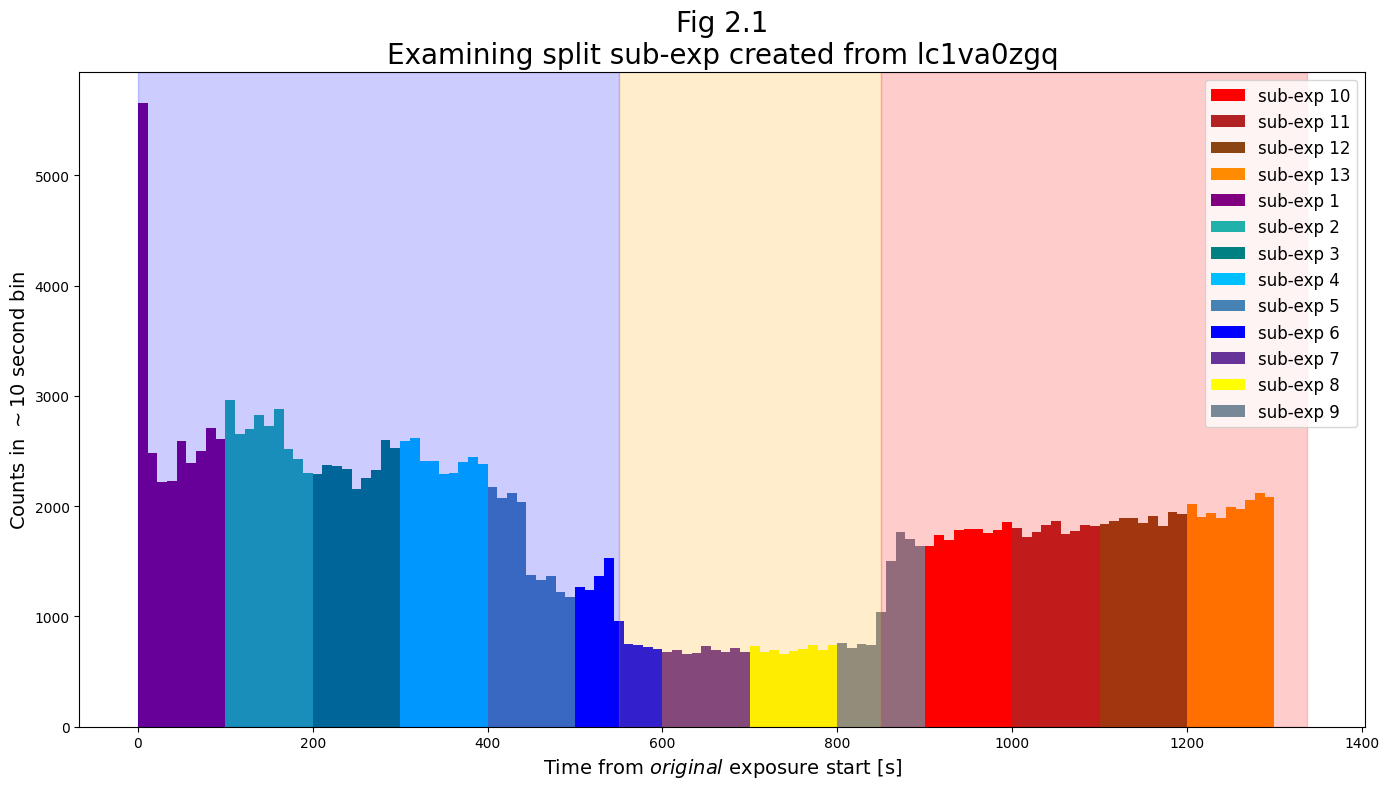

In [15]:
# Creating an array of colors for this exposure to be used in plotting
colors = [
    'red',
    'firebrick',
    'saddlebrown',
    'darkorange',
    'purple',
    'lightseagreen',
    'teal',
    'deepskyblue',
    'steelblue',
    'blue',
    'rebeccapurple',
    'yellow',
    'lightslategrey'
]

# Create the plot:
fig = plt.figure(figsize=(14, 8))

# Gather the split sub-exposure files:
spec_outlist = sorted(glob.glob('./output/regular_intervals/*fits'))

# Make histogram lightcurves as in previous plots:
# Binsize of lightcurve histogram in seconds
binsize = 10

# For each of our newly split up files:
for i in range(len(spec_outlist)):
    splitfile = spec_outlist[i]
    epoch_number = splitfile.split('_')[2]

    # Read in the file as a table of events:
    events_table = Table.read(splitfile, 1)
    event_times = events_table['TIME']

    hist = plt.hist(
        event_times,
        bins=int((max(event_times)-min(event_times))/binsize),
        alpha=1,
        color=colors[i],
        label=f"sub-exp {epoch_number}"
    )

# Add time ranges "epochs" or "windows of time" as transparent spans:
for epoch_time, color in zip(epoch_markers, ['b', 'orange', 'r']):
    plt.axvspan(
        epoch_time[0], epoch_time[1],
        color=color,
        alpha=0.2,
        label=None
    )

# Format the Figure
plt.legend(fontsize=12)

plt.title(f"Fig 2.1\nExamining split sub-exp created from {transit_basename}",
          size=20)
plt.xlabel("Time from $original$ exposure start [s]",
           fontsize=14)
plt.ylabel(fr"Counts in $\sim${binsize} second bin",
           fontsize=14)

plt.tight_layout()

plt.savefig(plots_dir / 'subexps.png',
            bbox_inches='tight',
            dpi=200)

### Exercise 2: *Examining epoch 1.5*

From Exercise 1, you have an additional epoch, from 450-550 seconds, which overlaps with the end of epoch 1, and has a flux between epoch 1 and epoch 2.

We wish to know whether the data taken during epoch 1.5 more closely aligns with that during epoch 1 or 2. To analyze this,

* **2.1:** Run epoch 1.5's data through `CalCOS`

* **2.2:** Plot epoch 1.5 alongside epochs 1 and 2 in the wavelength range around 1275 Å (*i.e. recreate Fig. 3.2 without epoch 3 and with epoch 1.5*).

* **2.3:** Briefly analyze whether epoch 1.5 is more in line with epoch 1 or 2, and consider how this knowledge may be useful. Consider whether our approach here to answering this question has any major flaws.

In [16]:
# Your code here:

**This is certainly not an exhaustive analysis,** and we do not claim in this Notebook to have made any measurements confirming or quantifying a transit.

However, you should now be equipped to use the `splittag` tool to subdivide exposures to look for time-variable phenomena.

## Congratulations! You finished this Notebook!
<font size="5">There are more COS data walkthrough Notebooks on different topics. You can find them <a href="https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/COS">here</a>.</font>


---
## About this Notebook
**Author:** Nat Kerman

**Curator:** Anna Payne apayne@stsci.edu

**Contributors:** This Notebook drew from a previously existing [Notebook written by Justin Ely](https://github.com/justincely/AAS224/blob/master/splittag_tutorial.ipynb).

**Updated On:** 2022-01-04


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `matplotlib`](https://matplotlib.org/3.4.3/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)


<hr>

[Top of Page](#topSp)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

# Exercise Solutions

In [17]:
# Exercise 1:

# Make the folder in which to store the newly split corrtag files:
spec_int_dir2 = output_dir / 'spec_intervals_Ex1'
# A second output directory for files split on specified intervals
spec_int_dir2.mkdir(exist_ok=True)

# List the specified times
split_list = [0, 450, 550, 1337]

# Run splittag using our specified times:
splittag.splittag(infiles=transit_exp,
                  outroot=spec_int_dir2 / 'transit_basename',
                  time_list=split_list)

output/spec_intervals_Ex1/transit_basename_1_1_corrtag_a.fits written


output/spec_intervals_Ex1/transit_basename_2_1_corrtag_a.fits written


output/spec_intervals_Ex1/transit_basename_3_1_corrtag_a.fits written


In [18]:
# Exercise 2.1 (CalCOS):

# Make a sub-directory of output/calcos/examples named for this epoch.
# We'll call the epoch "1.5" because it's between epochs 1 and 2
calcos_dir = Path('./output/calcos') 
examples_dir = calcos_dir / 'examples'
epoch_dir = examples_dir / 'epoch1.5'

calcos_dir.mkdir(exist_ok=True)
examples_dir.mkdir(exist_ok=True)
epoch_dir.mkdir(exist_ok=True)

# Extract the spectrum from the 2nd sub-exposure in spec_intervals_Ex1:
try:
    calcos.calcos(
        'output/spec_intervals_Ex1/transit_basename_2_corrtag_a.fits',
        outdir=epoch_dir,
        verbosity=0
    )
except RuntimeError as e:
    print('An error occured', e)

CALCOS version 3.6.1


numpy version 2.3.5


astropy version 7.1.1


Begin 25-Nov-2025 00:55:46 UTC


ERROR:  output files already exist:


ERROR:    output/calcos/examples/epoch1.5/transit_basename_2_corrtag_a.fits


ERROR:    output/calcos/examples/epoch1.5/transit_basename_2_flt_a.fits


ERROR:    output/calcos/examples/epoch1.5/transit_basename_2_counts_a.fits


ERROR:    output/calcos/examples/epoch1.5/transit_basename_2_x1d.fits


An error occured output files already exist


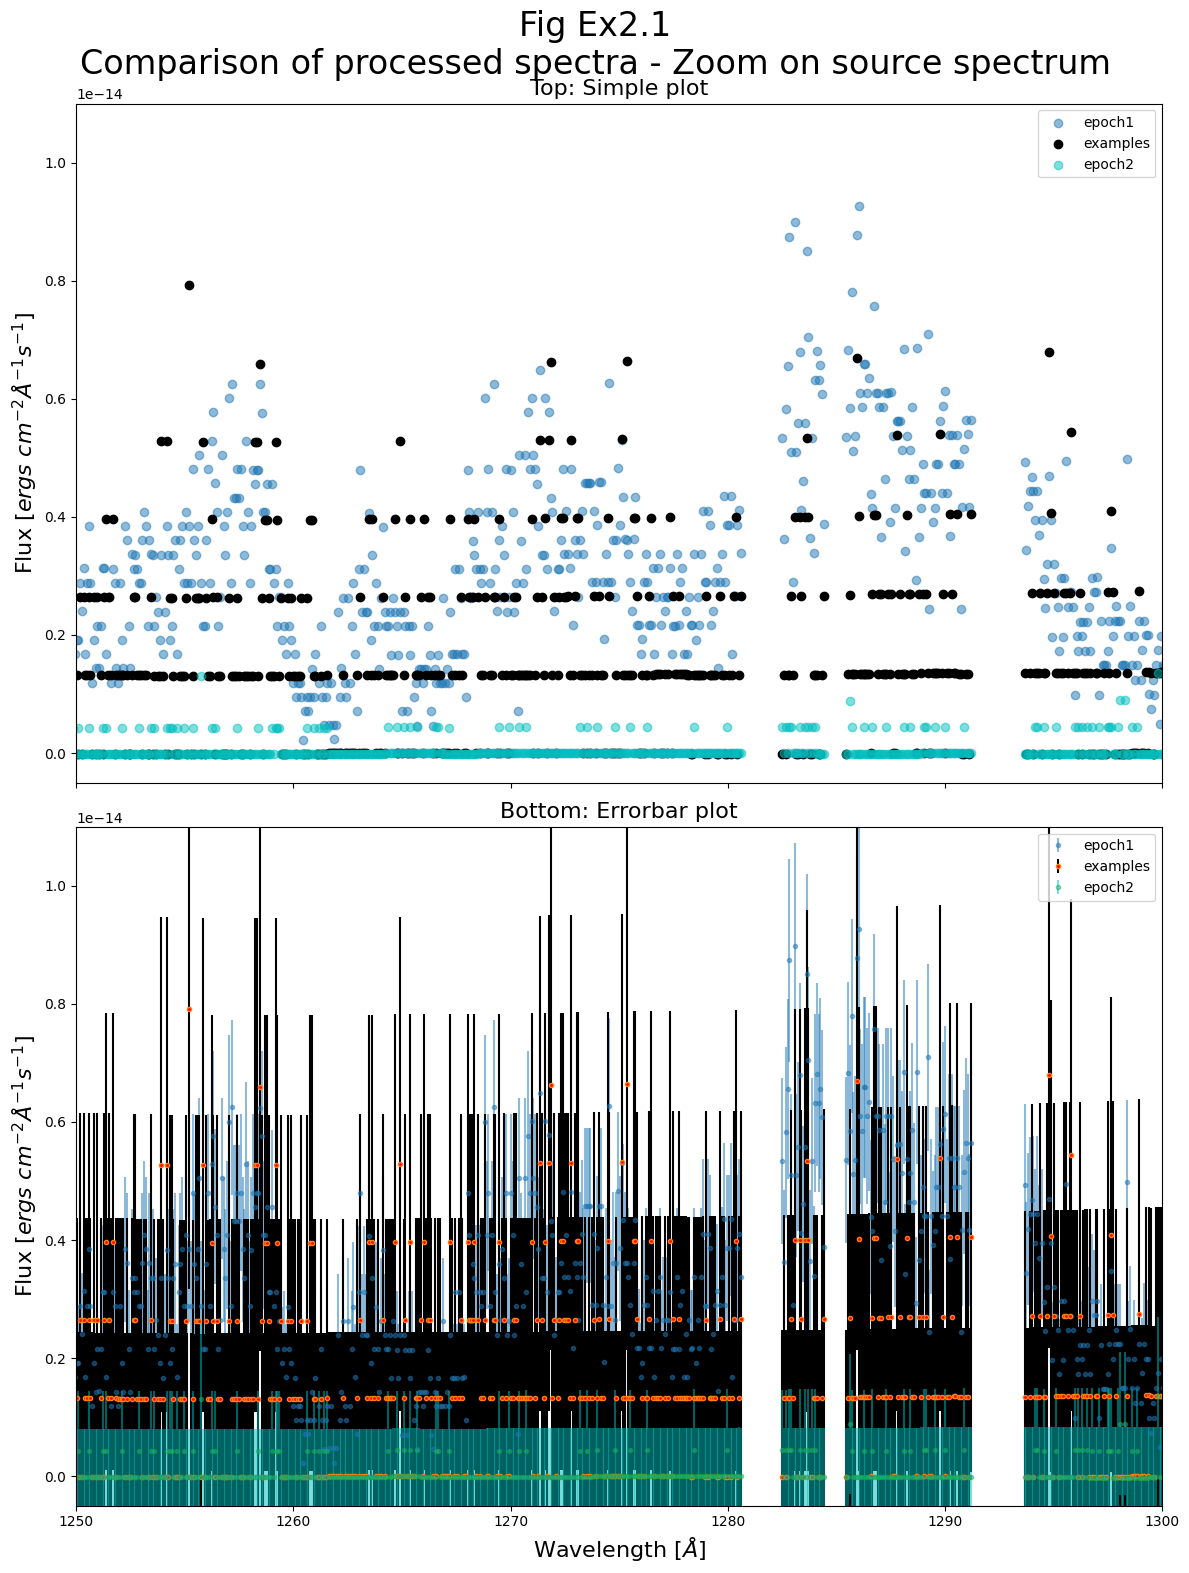

In [19]:
# Exercise 2.2 (Plotting):

if os.path.exists('output/calcos/epoch1/lc1va0zgq_1_x1d.fits') or os.path.exists('output/calcos/examples/epoch1.5/transit_basename_2_x1d.fits') or os.path.exists('output/calcos/epoch2/lc1va0zgq_2_x1d.fits'):

    # Set up figure
    fig, (ax0, ax1) = plt.subplots(2, 1,
                                   figsize=(12, 16),
                                   sharex=True)

    # Specify the files explicitly here
    processed_example_files = [
        'output/calcos/epoch1/lc1va0zgq_1_x1d.fits',
        'output/calcos/examples/epoch1.5/transit_basename_2_x1d.fits',
        'output/calcos/epoch2/lc1va0zgq_2_x1d.fits',
    ]

    for i in range(len(processed_example_files)):
        epoch_label = processed_example_files[i].split('/')[2]

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore',
                                    category=UnitsWarning,
                                    append=True)

            w, f, ferr, dq = Table.read(
                processed_example_files[i])[0]['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']

        # Filter to good quality data
        dq_mask = np.where(dq == 0)
        w, f, ferr = w[dq_mask], f[dq_mask], ferr[dq_mask]

        # Plot each epoch
        ax0.scatter(w, f,
                    # Epoch 2 should stand out
                    alpha=[0.5, 1, 0.5][i],
                    c=['C0', 'k', 'c'][i],
                    linestyle='-',
                    # Label with the epoch name
                    label=epoch_label)

        # Plot each epoch
        ax1.errorbar(w, f, yerr=ferr,
                     # Epoch 2 should stand out
                     alpha=[0.5, 1, 0.5][i],
                     marker='.',
                     markerfacecolor=['C0', 'r', 'c'][i],
                     linestyle='',
                     ecolor=['C0', 'k', 'c'][i],
                     # Label with the epoch name
                     label=epoch_label)

    # Format both subplots
    # Zoom to 1225 - 1300 Angstrom
    ax0.set_xlim(1250, 1300)
    ax1.set_xlim(1250, 1300)
    ax0.set_ylim(-5.E-16, 1.1E-14)
    ax1.set_ylim(-5.E-16, 1.1E-14)

    ax0.set_title("Top: Simple plot",
                  fontsize=16)
    ax1.set_title("Bottom: Errorbar plot",
                  fontsize=16)
    plt.suptitle(
        "Fig Ex2.1\nComparison of processed spectra - Zoom on source spectrum",
        size=24
    )

    ax1.set_xlabel(r"Wavelength [$\AA$]",
                   size=16)
    ax0.set_ylabel(r"Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]",
                   size=16)
    ax1.set_ylabel(r"Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]",
                   size=16)

    ax0.legend()
    ax1.legend()

    plt.tight_layout()

    plt.savefig(
        plots_dir / "Compare_spectrum_zoom_1275A_Ex2.png",
        dpi=200
    )
    
else:
    print('File not found, please run the previous cells first.')

**Ex 2.3 (Analysis):**

From a brief look, it seems that epoch 1.5 shares much more in common with epoch 1 (before the transit) than epoch 2 (during the transit).

If we wished to get as good a signal to noise ratio observation of the pre-transit spectrum as possible, we might include epochs 1 and 1.5 together to get additional counts.

Note that epoch 1 contains all the counts from epoch 1.5, while epoch 2 does not. Thus this is not a perfect test. However, the vast majority of epoch 1's counts do *not* overlap with epoch 1.5 (see fig  2.1), so this is an acceptable "first pass" test. It's also possible that the very low number of counts, especially in epochs 1.5 and 2, does not give us the signal-to-noise we would need to accurately distinguish the epochs.